In [33]:
import sys
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve, mean_squared_error

from lightgbm import LGBMClassifier, plot_importance, plot_tree

from quant.Classification import Classification
from quant.factor import get_factors, get_label
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.set_printoptions(precision=4, suppress=True)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [34]:
klines_1h_file = 'data/futures_klines_1h_BTCUSDT_20200101_20220430.zip'
klind_df = pd.read_csv(klines_1h_file, index_col=0, parse_dates=True)
klind_df.shape

(20279, 9)

In [35]:
kline_factors = get_factors(klind_df, sign_ratio=1)
kline_factors.head()

,Price,Returns,CumReturns,Log_Returns,Returns_Ratio,O-C,H-L,PR5,PR10,PR20,PR30,PR60,MOM5,MOM10,MOM20,MOM30,MOM60,SMA5,SMA10,SMA20,SMA30,SMA60,EMA,Sign
datetime,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03 13:00:00,7346.0700,0.0033,0.0243,0.0033,0.9873,-24.7600,68.1500,-0.0050,0.0041,0.0151,0.0068,-0.0020,88.0700,398.7200,379.2100,238.5100,135.8300,7332.1800,7273.3880,7112.6480,7113.7007,7156.3930,7171.4641,0
2020-01-03 14:00:00,7252.7000,-0.0127,0.0113,-0.0128,1.0087,93.0400,130.9500,-0.0247,-0.0497,-0.0131,-0.0185,-0.0166,-92.4500,48.3300,282.8500,104.1400,14.7100,7313.6900,7278.2210,7126.7905,7117.1720,7156.6382,7171.4721,1
2020-01-03 15:00:00,7316.0100,0.0087,0.0201,0.0087,1.0092,-63.2900,71.5600,0.0135,0.0072,0.0074,0.0072,0.0110,6.0100,100.4200,336.5700,156.6000,94.3600,7314.8920,7288.2630,7143.6190,7122.3920,7158.2108,7171.4864,1
2020-01-03 16:00:00,7383.0000,0.0092,0.0295,0.0091,0.9959,-67.6400,118.2200,0.0053,0.0117,0.0141,0.0094,0.0102,44.8900,186.0000,438.0500,225.1900,169.1400,7323.8700,7306.8630,7165.5215,7129.8983,7161.0298,7171.5072,0
2020-01-03 17:00:00,7352.9000,-0.0041,0.0253,-0.0041,0.9983,30.1000,67.1100,-0.0018,-0.0042,-0.0082,-0.0011,-0.0050,31.3300,154.8800,379.4000,216.6600,132.5900,7330.1360,7322.3510,7184.4915,7137.1203,7163.2397,7171.5251,0


In [36]:
X = kline_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio', 'Sign'], axis=1)
y = kline_factors['Sign']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 10108, 10109


In [38]:
X_train_scaler = MinMaxScaler().fit_transform(X_train)
X_test_scaler = MinMaxScaler().fit_transform(X_test)
print(f"Train and Test Size {len(X_train_scaler)}, {len(X_test_scaler)}")

Train and Test Size 10108, 10109


In [39]:
best_param = {'num_leaves': 10, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.25, 'colsample_bytree': 0.5}

gbm = LGBMClassifier(**best_param, force_row_wise=True, random_state=64, device='gpu')
gbm.fit(X_train_scaler,
        y_train,
        eval_set=[(X_train_scaler, y_train), (X_test_scaler, y_test)],
        eval_metric='logloss',
        feature_name=X_train.columns.to_list())

[1]	training's binary_logloss: 0.689601	valid_1's binary_logloss: 0.698692
[2]	training's binary_logloss: 0.686912	valid_1's binary_logloss: 0.699456
[3]	training's binary_logloss: 0.685186	valid_1's binary_logloss: 0.699917
[4]	training's binary_logloss: 0.683313	valid_1's binary_logloss: 0.705918
[5]	training's binary_logloss: 0.680724	valid_1's binary_logloss: 0.707324
[6]	training's binary_logloss: 0.679047	valid_1's binary_logloss: 0.709744
[7]	training's binary_logloss: 0.677611	valid_1's binary_logloss: 0.711643
[8]	training's binary_logloss: 0.676068	valid_1's binary_logloss: 0.71286
[9]	training's binary_logloss: 0.674563	valid_1's binary_logloss: 0.713789
[10]	training's binary_logloss: 0.673187	valid_1's binary_logloss: 0.713084
[11]	training's binary_logloss: 0.672064	valid_1's binary_logloss: 0.714592
[12]	training's binary_logloss: 0.671077	valid_1's binary_logloss: 0.7207
[13]	training's binary_logloss: 0.669952	valid_1's binary_logloss: 0.739752
[14]	training's binary_l

LGBMClassifier(colsample_bytree=0.5, device='gpu', force_row_wise=True,
               learning_rate=0.25, max_depth=5, min_child_weight=3,
               num_leaves=10, random_state=64)

In [40]:
y_pred = gbm.predict(X_test_scaler)
y_pred

array([1, 1, 1, ..., 1, 1, 0])

### Trading Strategy


In [41]:
# Create a new dataframe to subsume outsample data
df = kline_factors[-len(y_test):]

# Predict the signal and store in predicted signal column
df['Signal'] = y_pred

# Calculate the strategy returns
df['Strategy'] = df['Log_Returns'] * df['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df.index = df.index.tz_localize('utc')

# Check the output
df[['Price', 'Log_Returns', 'Signal', 'Strategy']].tail(10)

,Price,Log_Returns,Signal,Strategy
datetime,,,,
2022-04-30 13:00:00+00:00,38490.4000,-0.0008,1,-0.0000
2022-04-30 14:00:00+00:00,38238.3000,-0.0066,1,-0.0066
2022-04-30 15:00:00+00:00,38439.9000,0.0053,1,0.0053
2022-04-30 16:00:00+00:00,38408.7000,-0.0008,1,-0.0008
2022-04-30 17:00:00+00:00,38271.3000,-0.0036,1,-0.0036
2022-04-30 18:00:00+00:00,38325.1000,0.0014,1,0.0014
2022-04-30 19:00:00+00:00,38447.7000,0.0032,1,0.0032
2022-04-30 20:00:00+00:00,38313.4000,-0.0035,1,-0.0035
2022-04-30 21:00:00+00:00,38284.4000,-0.0008,1,-0.0008


Start date,2021-03-04
End date,2022-04-30
Total months,481
,Backtest
Annual return,-2.295%
Cumulative returns,-60.604%
Annual volatility,10.711%
Sharpe ratio,-0.16
Calmar ratio,-0.04
Stability,0.67
Max drawdown,-64.212%


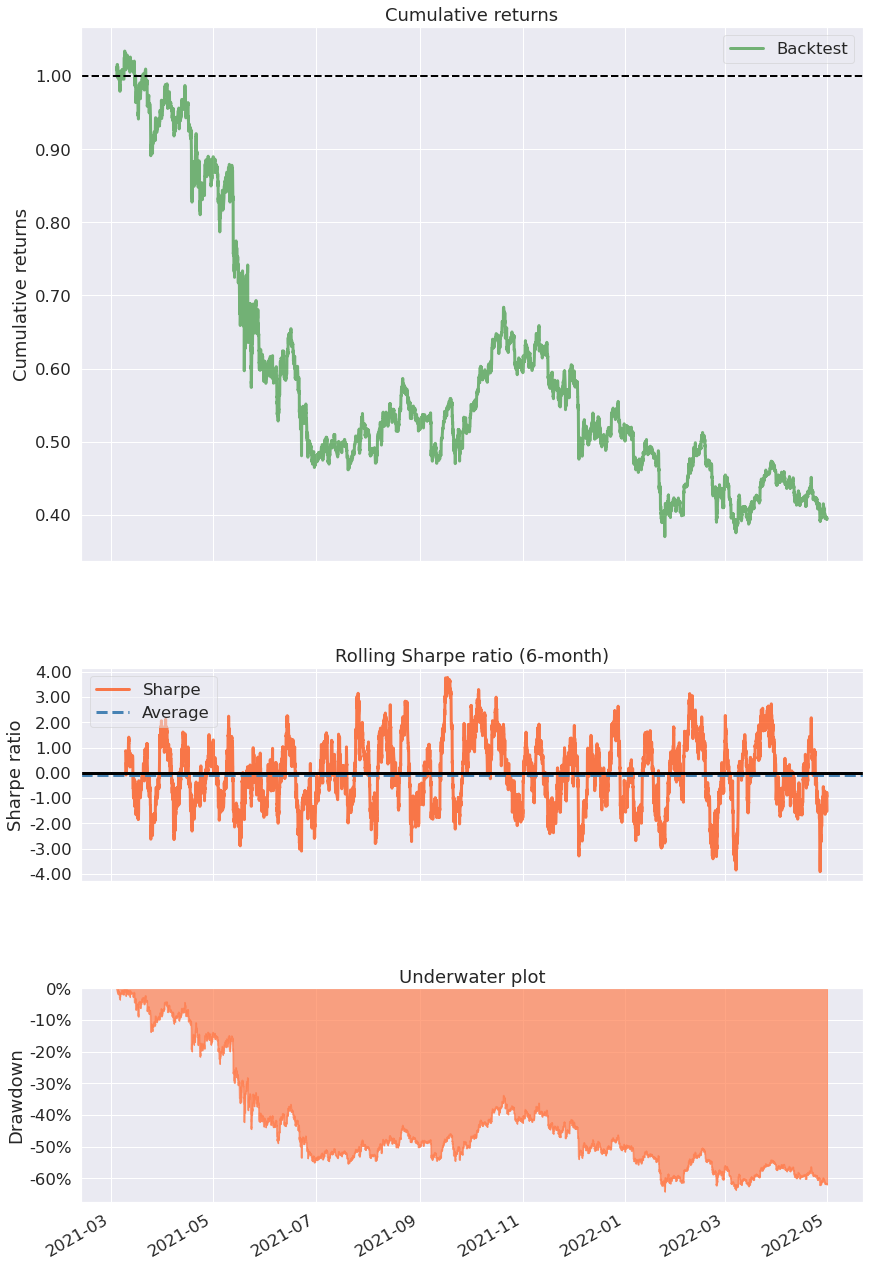

In [42]:
import pyfolio as pf

pf.create_simple_tear_sheet(df['Strategy'])

### Kelly

In [43]:
# Create a new dataframe to subsume outsample data
df = kline_factors[-len(y_test):]

# Predict the signal and store in predicted signal column
df['Signal'] = y_pred

# Calculate the strategy returns
df['Strategy'] = df['Log_Returns'] * (2 * gbm.predict_proba(X_test_scaler)[:,1] - 1) * df['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df.index = df.index.tz_localize('utc')

# Check the output
df[['Price', 'Log_Returns', 'Signal', 'Strategy']].tail(10)

,Price,Log_Returns,Signal,Strategy
datetime,,,,
2022-04-30 13:00:00+00:00,38490.4000,-0.0008,1,-0.0000
2022-04-30 14:00:00+00:00,38238.3000,-0.0066,1,-0.0047
2022-04-30 15:00:00+00:00,38439.9000,0.0053,1,0.0018
2022-04-30 16:00:00+00:00,38408.7000,-0.0008,1,-0.0001
2022-04-30 17:00:00+00:00,38271.3000,-0.0036,1,-0.0018
2022-04-30 18:00:00+00:00,38325.1000,0.0014,1,0.0000
2022-04-30 19:00:00+00:00,38447.7000,0.0032,1,0.0010
2022-04-30 20:00:00+00:00,38313.4000,-0.0035,1,-0.0002
2022-04-30 21:00:00+00:00,38284.4000,-0.0008,1,-0.0001


Start date,2021-03-04
End date,2022-04-30
Total months,481
,Backtest
Annual return,-17.99%
Cumulative returns,-99.965%
Annual volatility,5.331%
Sharpe ratio,-3.69
Calmar ratio,-0.18
Stability,0.99
Max drawdown,-99.965%


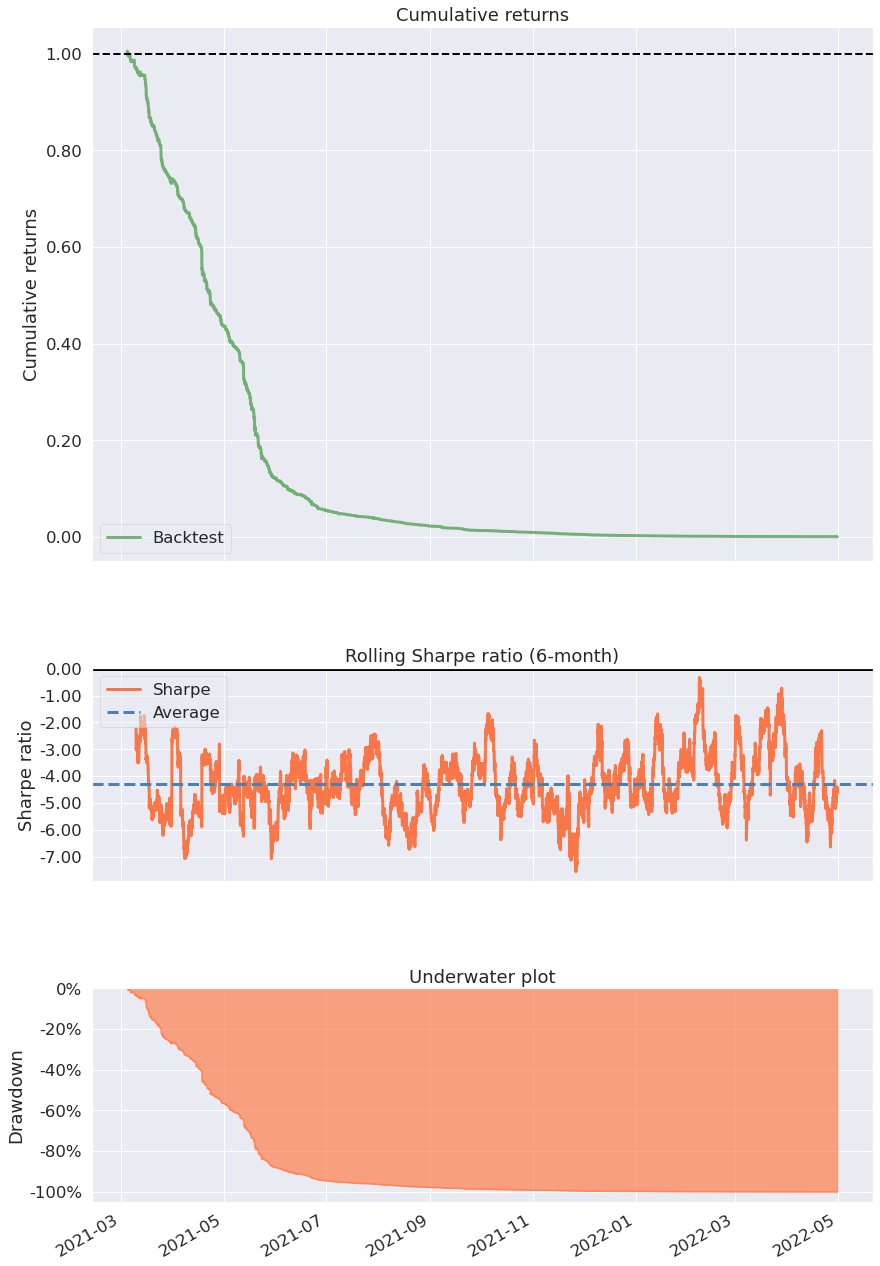

In [44]:
pf.create_simple_tear_sheet(df['Strategy'])